In [1]:
import sys
import os

cur_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(cur_dir)

from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds, DatasetName
from tools.utils import set_seed
import numpy as np

set_seed(1234)

2023-07-02 21:45:46.278910: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-02 21:45:46.307658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 21:45:46.725709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
radioml_ds = make_sigmod_ds(DatasetName.RADIOML_2016)
radioml_ds.load(cur_dir + "/data/radioml_2016/RML2016.10a_dict.pkl")

In [3]:
from models.fabric import make_sigmod_model, Convolution01xConfiguration, ModelName

cnn_v1_configuration = Convolution01xConfiguration(
    input_shape=(128, 2),
    n_classes=len(radioml_ds.get_modulations()),
    output_channels=[32, 48, 64, 96, 128, 192],
    kernel_sizes=[8, 8, 8, 8, 8, 8],
    paddings=["same", "same", "same", "same", "same", "same"],
    max_pool_sizes=[1, 1, 2, 1, 2, 1],
    max_pool_strides=[1, 1, 2, 1, 2, 1],
    avg_size=32,
    dense_sizes=[],
)

model = make_sigmod_model(ModelName.CNN_1D_V012, cnn_v1_configuration)

# model.summary()
splitted_radioml_ds = radioml_ds.split_train_val_test(0.8, 0.1)

2023-07-02 21:45:48.978324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 21:45:48.994569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 21:45:48.994694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
import tensorflow as tf

def step_decay(epoch):
    lrate = 0.001
    factor = epoch // 8
    lrate /= 10**factor
    return lrate


lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

N_EPOCHS = 16
BATCH_SIZE = 256

h = model.fit(
    splitted_radioml_ds.train.data,
    splitted_radioml_ds.train.labels,
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(splitted_radioml_ds.val.data, splitted_radioml_ds.val.labels),
    callbacks=[lrate]
)


Epoch 1/16


2023-07-02 21:45:51.498870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-02 21:45:52.472372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-02 21:45:52.474270: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f2d99c39ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-02 21:45:52.474283: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2023-07-02 21:45:52.477016: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-02 21:45:52.559788: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lif

688/688 [==============================] - 13s 13ms/step - loss: 1.7597 - accuracy: 0.3402 - val_loss: 1.4880 - val_accuracy: 0.4495 - lr: 0.0010
Epoch 2/16
688/688 [==============================] - 8s 12ms/step - loss: 1.3587 - accuracy: 0.4815 - val_loss: 1.2875 - val_accuracy: 0.5018 - lr: 0.0010
Epoch 3/16
688/688 [==============================] - 8s 12ms/step - loss: 1.2423 - accuracy: 0.5249 - val_loss: 1.2333 - val_accuracy: 0.5272 - lr: 0.0010
Epoch 4/16
688/688 [==============================] - 8s 12ms/step - loss: 1.1923 - accuracy: 0.5458 - val_loss: 1.1780 - val_accuracy: 0.5526 - lr: 0.0010
Epoch 5/16
688/688 [==============================] - 8s 12ms/step - loss: 1.1674 - accuracy: 0.5557 - val_loss: 1.1757 - val_accuracy: 0.5571 - lr: 0.0010
Epoch 6/16
688/688 [==============================] - 8s 12ms/step - loss: 1.1501 - accuracy: 0.5630 - val_loss: 1.1565 - val_accuracy: 0.5630 - lr: 0.0010
Epoch 7/16
688/688 [==============================] - 8s 12ms/step - loss:

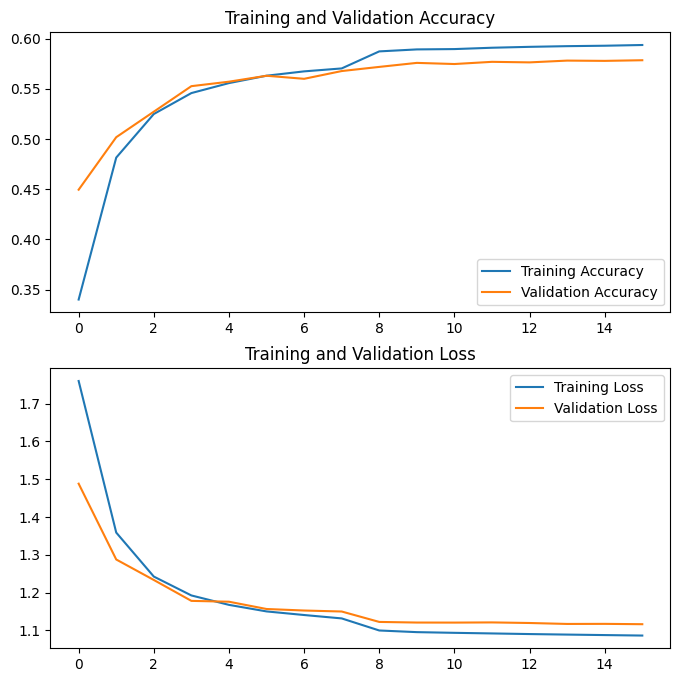

In [5]:
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_train, plot_snr_to_acc
plot_train(h.history)

688/688 [==============================] - 1s 2ms/step
Overall test accuracy: {'Overall': 0.5808181818181818}
8PSK test accuracy: 0.543613707165109
AM-DSB test accuracy: 0.6875621890547263
AM-SSB test accuracy: 0.8960155490767736
BPSK test accuracy: 0.6061479346781941
CPFSK test accuracy: 0.6290739782721159
GFSK test accuracy: 0.6537890044576523
PAM4 test accuracy: 0.6843702579666161
QAM16 test accuracy: 0.3534697953070394
QAM64 test accuracy: 0.5203211239337682
QPSK test accuracy: 0.5351101998974884
WBFM test accuracy: 0.27587890625
Confusion matrix:
[[1047   20  584   28   37   35   21   59   29   61    5]
 [   3 1382  434    5   11   45    6    2    0    2  120]
 [  14   58 1844   12   28   38   21    8    3   10   22]
 [  25   21  607 1262   22   12   90   19    3   13    8]
 [  27   30  555    9 1216   35   19   13    9   10   10]
 [   6   50  526   13   28 1320   10    4    2    4   56]
 [  14   21  451   68   19   19 1353    8    7    7   10]
 [  78   11  364   27   49   24   25

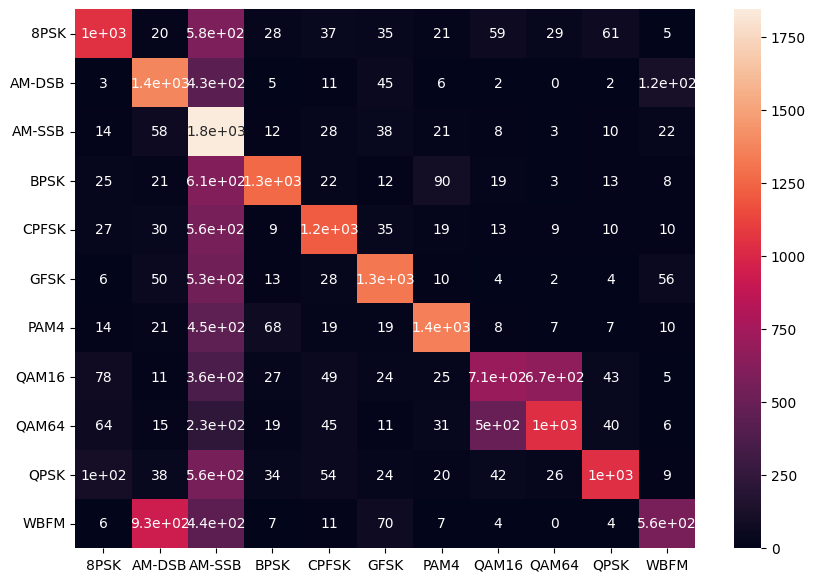

In [6]:
cm, accs = metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
)

SNR: -20 -- Overall test accuracy: 0.1009657594381036
SNR: -18 -- Overall test accuracy: 0.0967741935483871
SNR: -16 -- Overall test accuracy: 0.1009433962264151
SNR: -14 -- Overall test accuracy: 0.10045248868778281
SNR: -12 -- Overall test accuracy: 0.15115207373271888
SNR: -10 -- Overall test accuracy: 0.24930747922437674
SNR: -8 -- Overall test accuracy: 0.3653169014084507
SNR: -6 -- Overall test accuracy: 0.510677808727948
SNR: -4 -- Overall test accuracy: 0.6625222024866785
SNR: -2 -- Overall test accuracy: 0.7596830985915493
SNR: 0 -- Overall test accuracy: 0.8115808823529411
SNR: 2 -- Overall test accuracy: 0.8531021897810219
SNR: 4 -- Overall test accuracy: 0.8455813953488373
SNR: 6 -- Overall test accuracy: 0.8539626001780944
SNR: 8 -- Overall test accuracy: 0.8664226898444648
SNR: 10 -- Overall test accuracy: 0.8543956043956044
SNR: 12 -- Overall test accuracy: 0.8632246376811594
SNR: 14 -- Overall test accuracy: 0.8695652173913043
SNR: 16 -- Overall test accuracy: 0.8429517

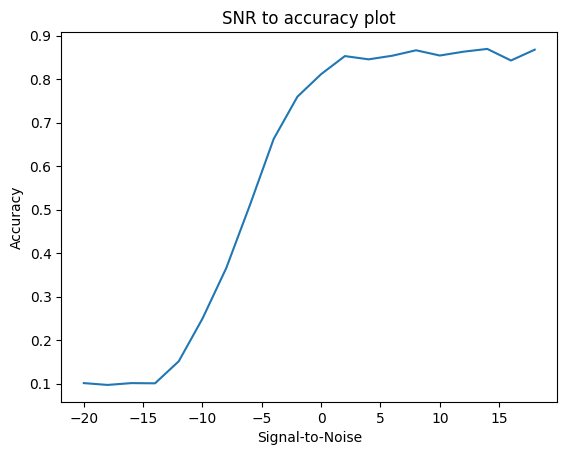

In [7]:
reload_module("evaluation.metric_evaluation")
from evaluation.metric_evaluation import snr_to_metric_evaluation

snr_to_acc = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
)
plot_snr_to_acc(snr_to_acc)

In [8]:
from evaluation.results_serialization import dump_results

from copy import deepcopy

history = deepcopy(h.history)
history["lr"] = list(map(lambda x: float(x), history["lr"]))

dump_results(
    "cnn_test_results/",
    model=model,
    model_config=cnn_v1_configuration,
    model_name=ModelName.CNN_1D_V012,
    train_history=history,
    cm_test=cm,
    cls_to_acc_test=accs,
    snr_to_acc_test=snr_to_acc,
    dump_model=True,
)

HHHI


In [14]:
reload_module("evaluation.results_serialization")
from evaluation.results_serialization import load_results
from pprint import pprint
results = load_results("cnn_test_results/", load_model=True)

pprint(results)
print(results["model"])

{'cls_to_acc_test': {'8PSK': 0.543613707165109,
                     'AM-DSB': 0.6875621890547263,
                     'AM-SSB': 0.8960155490767736,
                     'BPSK': 0.6061479346781941,
                     'CPFSK': 0.6290739782721159,
                     'GFSK': 0.6537890044576523,
                     'Overall': 0.5808181818181818,
                     'PAM4': 0.6843702579666161,
                     'QAM16': 0.3534697953070394,
                     'QAM64': 0.5203211239337682,
                     'QPSK': 0.5351101998974884,
                     'WBFM': 0.27587890625},
 'cm_test': [[1047, 20, 584, 28, 37, 35, 21, 59, 29, 61, 5],
             [3, 1382, 434, 5, 11, 45, 6, 2, 0, 2, 120],
             [14, 58, 1844, 12, 28, 38, 21, 8, 3, 10, 22],
             [25, 21, 607, 1262, 22, 12, 90, 19, 3, 13, 8],
             [27, 30, 555, 9, 1216, 35, 19, 13, 9, 10, 10],
             [6, 50, 526, 13, 28, 1320, 10, 4, 2, 4, 56],
             [14, 21, 451, 68, 19, 19, 1353, 8, 7, 7

In [15]:
snr_to_acc = snr_to_metric_evaluation(
    results["model"],
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
)


SNR: -20 -- Overall test accuracy: 0.1009657594381036
SNR: -18 -- Overall test accuracy: 0.0967741935483871
SNR: -16 -- Overall test accuracy: 0.1009433962264151
SNR: -14 -- Overall test accuracy: 0.10045248868778281
SNR: -12 -- Overall test accuracy: 0.15115207373271888
SNR: -10 -- Overall test accuracy: 0.24930747922437674
SNR: -8 -- Overall test accuracy: 0.3653169014084507
SNR: -6 -- Overall test accuracy: 0.510677808727948
SNR: -4 -- Overall test accuracy: 0.6625222024866785
SNR: -2 -- Overall test accuracy: 0.7596830985915493
SNR: 0 -- Overall test accuracy: 0.8115808823529411
SNR: 2 -- Overall test accuracy: 0.8531021897810219
SNR: 4 -- Overall test accuracy: 0.8455813953488373
SNR: 6 -- Overall test accuracy: 0.8539626001780944
SNR: 8 -- Overall test accuracy: 0.8664226898444648
SNR: 10 -- Overall test accuracy: 0.8543956043956044
SNR: 12 -- Overall test accuracy: 0.8632246376811594
SNR: 14 -- Overall test accuracy: 0.8695652173913043
SNR: 16 -- Overall test accuracy: 0.8429517